<a href="https://colab.research.google.com/github/notanhour/denoise/blob/main/conquer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from PIL import Image as im
from matplotlib import colors
import numpy as np
import requests

Задаем цвет

In [78]:
def set_color(color):
  try:
    color = [int(x) for x in (color, color, color)]
  except ValueError:
    color = [int(x * 255) for x in colors.to_rgb(color)]
  return color

"Grabby Aliens"

In [79]:
def conquer(image, bound):
    result = image.copy()
    pad = 5
    for y in range(height):
        for x in range(width):
            pixel = image[y][x]
            if abs(np.sum(pixel) - bound) > pad:  # если пиксель 'хороший'
                result[y][x] = pixel
                if y - 1 >= 0 and abs(np.sum(image[y - 1][x]) - bound) < pad + 1:
                    result[y - 1][x] = pixel
                if x + 1 < width and abs(np.sum(image[y][x + 1]) - bound) < pad + 1:
                    result[y][x + 1] = pixel
                if y + 1 < height and abs(np.sum(image[y + 1][x]) - bound) < pad + 1:
                    result[y + 1][x] = pixel
                if x - 1 >= 0 and abs(np.sum(image[y][x - 1]) - bound) < pad + 1:
                    result[y][x - 1] = pixel
    return result

А это работает быстрее!

In [80]:
def conquer(image, bound):
    result = image.copy()
    pad = 5
    good_pixels = abs(np.sum(image, axis=2) - bound) > pad
    for y_shift, x_shift in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
        shifted_good = np.roll(good_pixels, shift=(y_shift, x_shift), axis=(0, 1))  # сдвигаем маску 'хороших' пикселей
        # Не работаем с краем, который был 'перенесен' через границы массива
        if y_shift == 1:
            shifted_good[0, :] = False  # верхняя граница
        elif y_shift == -1:
            shifted_good[-1, :] = False  # нижняя граница
        elif x_shift == 1:
            shifted_good[:, 0] = False  # левая граница
        elif x_shift == -1:
            shifted_good[:, -1] = False  # правая граница
        neighbors_to_update = shifted_good & ~good_pixels  # маска 'плохих' соседей
        result[neighbors_to_update] = np.roll(image, shift=(y_shift, x_shift), axis=(0, 1))[neighbors_to_update]  # 'плохие' соседи заменяются значениями сдвинутых 'хороших' пикселей
    return result




---



Загрузка фото

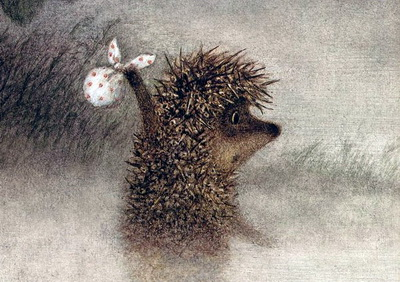

In [82]:
# image = im.open("point_test.png").convert("RGB")  # локально
url = requests.get("https://ic.pics.livejournal.com/osdru/28368153/14310/14310_original.jpg", stream=True)  # url
image = im.open(url.raw).convert("RGB")  # ...
width, height = image.size
array = np.array(image)  # изображение в массив (r, g, b)
image  # image.show()

Если на фото есть шум, то какого он цвета?

In [ ]:
color = set_color(input("Цвет шума: "))

Если его нет, то добавим!

Количество шума: 50
Цвет шума: red
Шум там, где (r + g + b) < 540


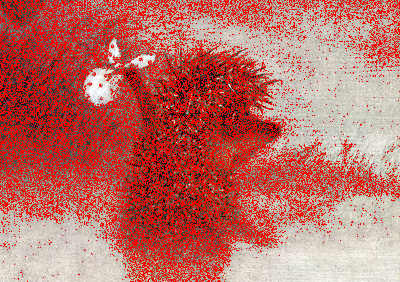

In [83]:
level = int(input("Количество шума: "))  # [0, 100]
color = set_color(input("Цвет шума: "))
maxi = int(input("Шум там, где (r + g + b) < "))
noise = np.random.random(array.shape[:2]) < (level / 100)
rgb = np.sum(image, 2)  # сумма (r, g, b)
array[noise & (rgb < maxi)] = color
image = im.fromarray(array)
image  # image.show()

Долой его!

In [84]:
stop = 0  # чем меньше, тем лучше
bound = sum(color)  # шум в районе этого значения
result = conquer(array, bound)

error = np.mean(abs(result - array))
while error > stop:
    array = result
    result = conquer(array, bound)
    error = np.mean(abs(result - array))

Показать результат

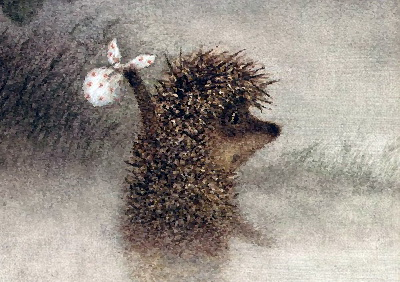

In [86]:
image = im.fromarray(result)  # массив в изображение
image  # image.show()